In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


%matplotlib inline

'''
Класс, представляющий собой одну кинематическую пару
'''
class KinematicPart:
    s = tf.constant(0, dtype=tf.float32)
    a = tf.constant(0, dtype=tf.float32)
    alpha = tf.constant(0, dtype=tf.float32)
    
    borderMin = tf.constant(0, dtype=tf.float32)
    borderMax = tf.constant(0, dtype=tf.float32)
    
    def __init__(self, s,a,alpha, bmin, bmax):
        self.s = tf.constant(s, dtype=tf.float32)
        self.a = tf.constant(a, dtype=tf.float32)
        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.borderMin = tf.constant(bmin, dtype=tf.float32)
        self.borderMax = tf.constant(bmax, dtype=tf.float32)
        
    def getMatrix(self, q):
        return [
            [tf.cos(q), -tf.sin(q)*tf.cos(self.alpha), tf.sin(q)*tf.sin(self.alpha), self.a*tf.cos(q)],
            [tf.sin(q), tf.cos(q)*tf.cos(self.alpha), -tf.cos(q)*tf.sin(self.alpha), self.a*tf.sin(q)],
            [0, tf.sin(self.alpha), tf.cos(self.alpha), self.s],
            [0, 0, 0, 1]
                         ]


'''
Класс робота, состоящего из пар
'''
class Robot:
    parts = []
    penaltiesMin = None
    penaltiesMax = None
    
    def __init__(self, parts):
        self.parts = parts
        self.penaltiesMin = [(p.borderMin) for p in self.parts]
        self.penaltiesMax = [(p.borderMax) for p in self.parts]
    
    '''
    Получить значение штрафа для данных обобщенных координат
    '''
    def penalty(self, Q, W1=1, W2=1):
        
        reduce_to_nil = lambda n: tf.cond(n > 0,
                                         lambda:tf.constant(0,dtype=tf.float32), lambda:tf.abs(n))
        
        return W1*tf.reduce_sum(
            tf.map_fn(reduce_to_nil, tf.subtract(Q, self.penaltiesMin))
        ) + W2*tf.reduce_sum(tf.map_fn(reduce_to_nil, tf.subtract(self.penaltiesMax, Q)))
    
    
    '''
    Получить координаты схвата (конечного звена)
    '''
    def getXYZ(self, Q):
        return self.getXYZPair(Q, len(self.parts))[:3]
    
    '''
    Получить координаты конкретной пары 
    '''    
    def getXYZPair(self, Q, pair):
        
        resultMatrix = tf.eye(4, dtype=tf.float32)
        
        for i,p in enumerate(self.parts):
            
            if i==pair:
                break
            
            resultMatrix = tf.matmul(resultMatrix,p.getMatrix(Q[i]))
        
        xyz1 = tf.matmul(resultMatrix,tf.constant([[0],[0],[0],[1]], dtype=tf.float32))
        #res = np.squeeze(xyz1,[3])
        return xyz1
    
    
    '''
    Массив координат всех пар (для построения графика)
    '''
    def getPairPoints(self, Q):
        
        result = []
        
        for i,p in enumerate(self.parts):
            pairXYZ = self.getXYZPair(Q,i)
            result.append([pairXYZ[0],pairXYZ[1], pairXYZ[2]])
        
        return result

    

In [2]:
tf.reset_default_graph()
r=np.pi/180.0
Z1 = KinematicPart(300, 0, np.pi/2, bmin=-150*r, bmax=150*r)
Z2 = KinematicPart(0, 250, 0, bmin=-30*r, bmax=150*r)
Z3 = KinematicPart(0, 160, 0, bmin=-150*r, bmax=80*r)
Z4 = KinematicPart(0, 0, np.pi/2, bmin=-150*r, bmax=80*r)
Z5 = KinematicPart(0, 72+124.17143421, 0, bmin=0*r, bmax=0*r)

parts = [Z1,Z2,Z3,Z4,Z5]

RV = Robot(parts)


In [3]:
trajectory = [
    [[606],[0],[300]],
    [[550],[30],[315]],
    [[520],[50],[327]],
    [[500],[80],[400]],
    [[470],[120],[430]],
#     [[397],[240],[330]]
]

In [4]:
#Q0 = tf.placeholder(tf.float32)
Q0 = tf.Variable([  0*r, 0*r, 0*r, 0*r, 0.000*r],dtype=tf.float32, name="Q_initial")
#Q0 = tf.Variable([-0.00081764*r,  0.38168061*r,  0.29301527*r,  0.34906584*r],dtype=tf.float32)

targetPlace = tf.placeholder(tf.float32, name="targetXYZ")
target = tf.Variable([[0],[0],[0]], dtype=tf.float32)
next_target = tf.assign(target, targetPlace)

xyz = RV.getXYZ(Q0)[:3]
penalty = RV.penalty(Q0, 9999, 9999)

loss = tf.reduce_sum(tf.sqrt(tf.pow(target-xyz, 2))) + penalty

global_step = tf.Variable(0.0, trainable=False, name="global_step")

epoch = tf.Variable(1, trainable=True, dtype=tf.int32, name="epoch")

new_epoch = tf.assign(epoch, epoch+1)
reset_epoch = tf.assign(epoch, 1)

initial_learning_rate = 0.25
starter_learning_rate = tf.train.exponential_decay(initial_learning_rate, epoch,
                                           1, 0.95, staircase=False)

learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                          10, 0.96, staircase=False)



optimizer = tf.train.AdamOptimizer(learning_rate)
grad = optimizer.compute_gradients(loss, [Q0])


best_loss = tf.Variable(tf.float32.max, dtype=tf.float32, name="best_loss")
best_q = tf.Variable([0,0,0,0,0], dtype=tf.float32, name="best_q")

best_loss_init = best_loss.assign(tf.float32.max)

assign_best_loss = tf.assign(best_loss,
                             tf.cond(best_loss>loss, lambda:loss, lambda:best_loss))

assign_best_q = tf.assign(best_q,
                          tf.cond(best_loss>loss, lambda:Q0, lambda:best_q))

new_best_loss = [assign_best_q, assign_best_loss]

error_decay = loss - best_loss

gradRV = tf.concat([
    tf.reshape(tf.slice(grad, [0,0,0], [1,1,4]),[4]), 
    [0]],0)

cn = tf.is_nan(grad[0][0])

grad_and_vars = [(tf.cond(tf.equal(cn[0],tf.constant(False)), 
                                  lambda:gradRV,
                                  lambda:tf.constant([1, 1, 1, 1, 0], dtype=tf.float32)
                                 ), grad[0][1])]


train = optimizer.apply_gradients(grad_and_vars,global_step=global_step)


reset_step = tf.variables_initializer([global_step])

nextQ = tf.assign(Q0, best_q)

model = tf.global_variables_initializer()


starting at Q: [ 0.  0.  0.  0.  0.] loss: 3.40282e+38
Steps 1431.0
bestQ: -0.001*r, 1.035*r, -0.419*r, -2.437*r, 0.000*r  bestLoss:  0.0292667


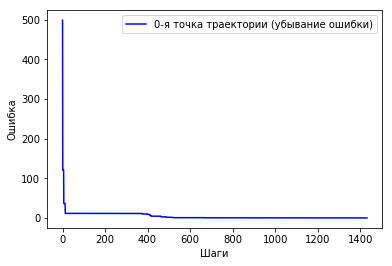

starting at Q: [ -1.11798836e-05   1.80648137e-02  -7.31883384e-03  -4.25351448e-02
   0.00000000e+00] loss: 3.40282e+38
Steps 1183.0
bestQ: 3.121*r, 16.912*r, 2.890*r, -54.592*r, 0.000*r  bestLoss:  0.0313492


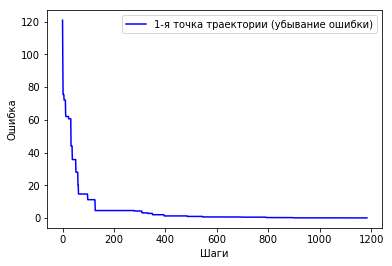

starting at Q: [ 0.05446401  0.29516736  0.0504457  -0.95281714  0.        ] loss: 3.40282e+38
Steps 1234.0
bestQ: 5.491*r, 19.021*r, 9.688*r, -70.740*r, 0.000*r  bestLoss:  0.0148773


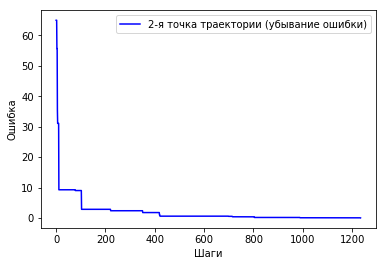

starting at Q: [ 0.09584071  0.33198586  0.16909234 -1.23464465  0.        ] loss: 3.40282e+38
Steps 1169.0
bestQ: 9.090*r, 24.468*r, 18.162*r, -77.414*r, 0.000*r  bestLoss:  0.0285034


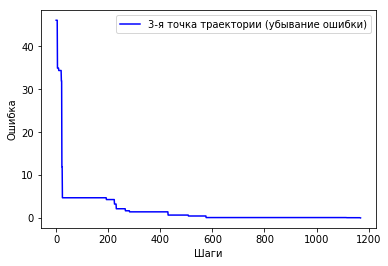

starting at Q: [ 0.15864874  0.4270497   0.31698817 -1.35113585  0.        ] loss: 3.40282e+38
Steps 1314.0
bestQ: 14.322*r, 26.865*r, 24.981*r, -85.528*r, 0.000*r  bestLoss:  0.0323792


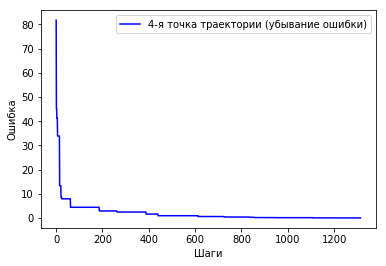

Wall time: 39.2 s


In [5]:
%%time

STEPS_IN_EPOCH = 2000
MAX_EPOCHS = 20
DECAY_PRECISION = 0.0009


traceLoss = []

with tf.Session() as session:
    session.run(model)
    i=0
    for t in trajectory:
        traceX = []
        traceY = []
        
        session.run(next_target,feed_dict={targetPlace:t})
        
        print("starting at", "Q:", session.run(Q0), "loss:", session.run(best_loss))
        
        while session.run(best_loss) >= 0.04:
            step = session.run(global_step)
            e = session.run(epoch)
            curStep=step+STEPS_IN_EPOCH*(e-1)
            session.run(train)
            decay = session.run(error_decay)
            session.run(new_best_loss)

            if step > STEPS_IN_EPOCH:
                if session.run(epoch) >= MAX_EPOCHS:
                    break

                session.run(new_epoch)
                session.run(reset_step)
            traceX.append(curStep)
            traceY.append(session.run(best_loss))
            traceLoss.append(session.run(loss))
    #         if(step % 50 == 0):
    #             print("epoch", session.run(epoch), "step", curStep, "decay:", decay, "loss:",
    #                   session.run(best_loss), "penalty: ", session.run(penalty))

        print("Steps",curStep)
        session.run(nextQ)
        session.run(reset_step)
        session.run(reset_epoch)
        
        print("bestQ: %.3f*r, %.3f*r, %.3f*r, %.3f*r, %.3f*r"% tuple(session.run(best_q)/r), " bestLoss: ", session.run(best_loss))
        session.run(best_loss_init)
#         mpl.rcParams['legend.fontsize'] = 10

        fig = plt.figure()
        ax = fig.gca()

        ax.plot(traceX, traceY, color="blue")
#         ax.plot(traceX[STEPS_IN_EPOCH:], traceY[STEPS_IN_EPOCH:], color="red")
#         ax.plot(traceX,traceLoss, color="blue", lw=0.2)

        ax.set_xlabel("Шаги")
        ax.set_ylabel("Ошибка")
        ax.legend(["%i-я точка траектории (убывание ошибки)" % i])

        plt.show()
        i = i + 1